# Chapter 16 Coroutines (1)

## Generators vs Coroutines

Python 2.5부터, generator에 `.send(value)` method가 추가되고, `yield`를 표현식 내에 사용할 수 있게 됨으로써, generator를 coroutine으로 사용할 수 있게 되었다.  
쉽게 얘기하면, 코루틴은 제네레이터의 특별한 형태라고 생각하면 되는데, 제네레이터는 `yield`로 값을 발생시키지만, 코루틴은 `yield`로 값을 받아올 수 있다. 

In [13]:
def simple_coroutine():
    print('-> coroutine started')
    x = yield
    print('-> coroutine received: ', x)

my_co = simple_coroutine()
my_co

<generator object simple_coroutine at 0x110feec80>

In [14]:
next(my_co)

-> coroutine started


In [15]:
my_co.send(42)

-> coroutine received:  42


StopIteration: 

## coroutine 의 상태

coroutine은 4가지의 상태를 가지고, `inspect.getgeneratorstate(...)` 함수를 사용해서 이를 확인할 수 있다.  
1. `GEN_CREATED` : coroutine이 활성화되지 않은 상태
2. `GEN_RUNNING` : 인터프리터에 의해 실행되고 있는 상태 (멀티쓰레드 어플리케이션 내에서만 볼 수 있다)
3. `GEN_SUSPENDED` : `yield`에서 값을 입력받기를 대기하고 있는 상태
4. `GEN_CLOSED` : coroutine이 끝난 상태

In [16]:
my_co2 = simple_coroutine()
my_co2.send(42)

TypeError: can't send non-None value to a just-started generator

처음에 coroutine 객체를 만들고, 값을 입력(send)하려고 하면 에러가 뜬다. coroutine을 사용가능한 상태(`GEN_SUSPENDED`)로 만들기 위해서는 처음에 `yield`가 등장하는 곳까지 코루틴을 진행시켜줘야하고 이러한 과정을 "priming"이라고 한다. 이렇게 만드는 방법은 `next(my_coro)` 혹은 `my_coro.send(None)`을 호출하는 것이다. 

In [18]:
def simple_coro2(a):
    print('-> Started: a =', a)
    b = yield a
    print('-> Received: b =', b)
    c = yield a + b
    print('-> Received: c =', c)
    
my_coro2 = simple_coro2(14)

from inspect import getgeneratorstate
getgeneratorstate(my_coro2)

'GEN_CREATED'

In [19]:
next(my_coro2)

-> Started: a = 14


14

In [20]:
getgeneratorstate(my_coro2)

'GEN_SUSPENDED'

In [21]:
my_coro2.send(28)

-> Received: b = 28


42

In [23]:
my_coro2.send(99)

-> Received: c = 99


StopIteration: 

In [24]:
getgeneratorstate(my_coro2)

'GEN_CLOSED'

## Priming 생략하는 Decorator

In [25]:
def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield average
        total += term
        count += 1
        average = total/count
        
coro_avg = averager()
next(coro_avg)
coro_avg.send(10)

10.0

In [26]:
coro_avg.send(30)

20.0

In [27]:
coro_avg.send(5)

15.0

coroutine을 활성화하는 일은 중요하지만, 쉽게 까먹을 수 있는 일이다. 따라서 이를 자동으로 해줄 수 있는 decorator를 만들어서 사용할 수 있다. 

In [30]:
from functools import wraps
def coroutine(func):
    @wraps(func)
    def primer(*args, **kwargs):
        gen = func(*args, **kwargs)
        next(gen)
        return gen
    return primer

@coroutine
def averager2():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield average
        total += term
        count += 1
        average = total/count
        
coro_avg2 = averager2()
from inspect import getgeneratorstate
getgeneratorstate(coro_avg2)

'GEN_SUSPENDED'

## Coroutine 종료와 예외처리

In [31]:
coro_avg2.send(40)

40.0

In [32]:
coro_avg2.send(50)

45.0

In [33]:
coro_avg2.send('spam')

TypeError: unsupported operand type(s) for +=: 'float' and 'str'

In [34]:
coro_avg2.send(60)

StopIteration: 

이렇게 coroutine 내에서 예외가 처리되지 않으면 해당 coroutine이 종료되고, 더 이상 값을 입력받을 수 없게 된다. 이를 이용해서 의도적으로 `None`과 같은 값을 보내 coroutine을 종료시킬 수도 있지만, 이를 직접적으로 처리하는 함수가 따로 존재한다. 

- `generator.throw(exc_type[, exc_value[, traceback]])`  
  - `yield` 표현식에 예외를 발생시킨다. 예외가 처리되면 다음 `yield`로 이동하고, 처리되지 않으면 caller로 예외가 전달된다.  
- `generator.close()`  
  - `yield` 표현식에 `GeneratorExit` 예외를 발생시킨다. 이 예외는 처리하지 않아도 `StopIteration` 예외나 에러가 발생하지 않는다. 

In [35]:
class DemoException(Exception):
    """An exception type for the demonstration."""

def demo_exc_handling():
    print('-> coroutione started')
    while True:
        try:
            x = yield
        except DemoException:
            print('*** DemoException handled. Continuing...')
        else:
            print('-> coroutine received: ', x)
    raise RuntimeError('This line should never run.')
    
exc_coro = demo_exc_handling()
next(exc_coro)

-> coroutione started


In [36]:
exc_coro.send(11)

-> coroutine received:  11


In [37]:
exc_coro.throw(DemoException)

*** DemoException handled. Continuing...


In [38]:
getgeneratorstate(exc_coro)

'GEN_SUSPENDED'

In [39]:
exc_coro.close()

In [40]:
getgeneratorstate(exc_coro)

'GEN_CLOSED'

## Coroutine syntax changes

1. 이전에는 generator 내에서 값을 return하면 SyntaxError를 발생시켰는데, 현재는 가능해졌다.  
2. `yield from`을 사용해서 복잡한 generator를 작게 쪼개서 사용할 수 있다. (리팩토링!)

### coroutine 내에서의 값 반환  

경우에 따라 `yield`를 거칠 때마다 값을 보여주지 않고, 결과값만 한 번에 보여주도록 구현해야할 수 있다. 이러한 경우에 유용하게 쓰일 수 있다. 

In [44]:
from collections import namedtuple

Result = namedtuple('Result', 'count average')

def averager():
    total = 0.0
    count = 0
    average = None
    while True:
        term = yield
        if term is None:
            break
        total += term
        count += 1
        average = total/count
    return Result(count, average)

coro_avg = averager()
next(coro_avg)
coro_avg.send(10)
coro_avg.send(30)
coro_avg.send(6.5)
coro_avg.send(None)

StopIteration: Result(count=3, average=15.5)

In [45]:
coro_avg2 = averager()
next(coro_avg2)
coro_avg2.send(10)
coro_avg2.send(30)
try:
    coro_avg2.send(None)
except StopIteration as exc:
    result = exc.value
    
result

Result(count=2, average=20.0)

### `yield from` 사용

- delegating generator : 내부에 `yield from <iterable>` 을 포함하는 generator 함수  
- sebgenerator : `yield from <iterable>` 내의 iterable part에서 얻어지는 generator  
- caller : delegating generator를 호출하는 client code

2가지 쓰임  
1. for문을 사용하지 않고 값을 여러 번 바깥으로 전달 가능(generator에서의 쓰임)  
2. `yield from`에 coroutine을 지정하면 해당 coroutine에서 return으로 반환한 값을 가져온다. (Syntax for Delegating to a Subgenerator)

In [46]:
def gen():
    for i in range(3):
        yield i
        
list(gen())

[0, 1, 2]

In [47]:
def gen2():
    yield from range(3)
    
list(gen())

[0, 1, 2]

2번 목적으로서 `yield from subcoroutine()`이 delegating generator `co` 내에서 작동하는 방식  
1. `next(co)`, `co.send(v)`를 호출하는 것은 곧장 `subcoroutine()`의 동작으로 연결되며, `co` 내부의 `yield from` 지점에서는 코드가 진행되지 않는다.  
2. 서브코루틴이 동작을 완료하여 `StopIteration` 예외를 일으키면 `yield from` 구문이 종료되고 다음 라인으로 실행 흐름이 이동한다. 

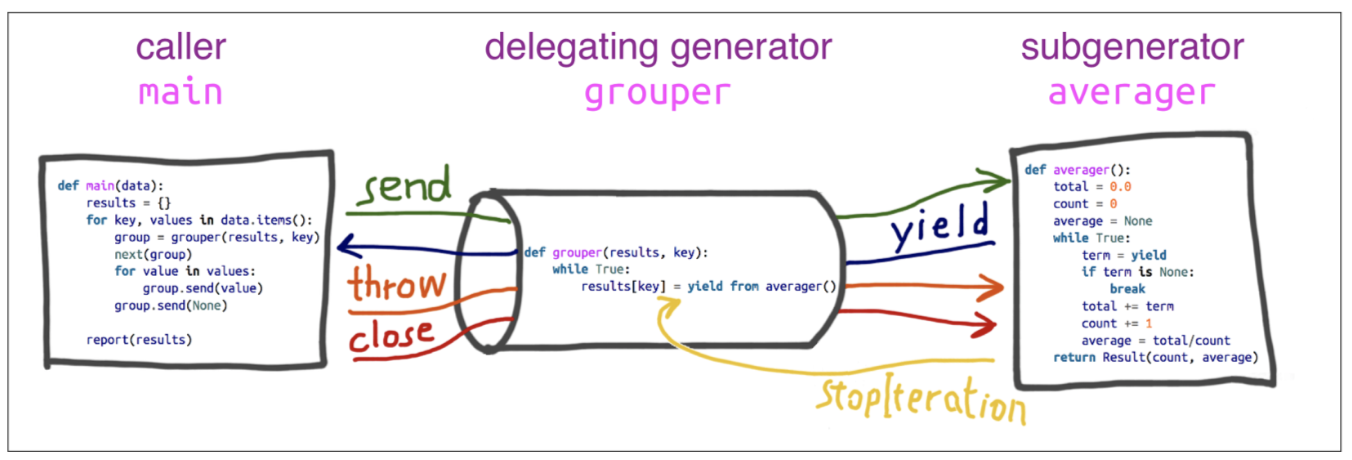

In [59]:
def number_coroutine():
    x = None
    while True:
        x = yield x
        if x == 3:
            return x
        
def print_coroutine():
    while True:
        x = yield from number_coroutine()
        print('print_coroutine:', x)
        
co = print_coroutine()
next(co)

x = co.send(1)
print(x)
x = co.send(2)
print(x)
co.send(3)

1
2
print_coroutine: 3
